# *ΥΠΟΛΟΓΙΣΤΙΚΗ ΝΟΗΜΟΣΥΝΗ* Εργαστηριακή Άσκηση Μέρος Α΄
> **Βασίλης Χαράλαμπος Αυγερινός ΑΜ: 1054298**   
> **Github link:** [https://github.com/wzrd13/CI_project_2021](https://github.com/wzrd13/CI_project_2021)

In [3]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

### Α1. Προεπεξεργασία και Προετοιμασία δεδομένων

**α)** Τα δεδομένα το **Mnist dataset** είναι είδη κεντραρισμένα οπότε όπως φαίνεται και παρακάτω για προεπεξεργασία  χρησιμοποιούνται οι μέθοδοι της κανονικοποίησης και της τυποποίησης.

In [4]:
'''Get Data'''

## Tranforms ##
# toTensor divides by 256 -> dataset values [0,1]
# normalize with std and mean
dt_trasforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Download Data apply trasnformations
trainset = MNIST(os.getcwd(), train=True, download=True, transform=dt_trasforms)
testset = MNIST(os.getcwd(), train=False, download=True, transform=dt_trasforms)

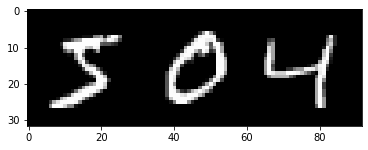

'std:'

0.9496731162071228

'mean:'

-0.03782825171947479

In [5]:
'''Test Data'''

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Create dataloader for testing data
test_data_loader = torch.utils.data.DataLoader(trainset, batch_size=4)
dataiter = iter(test_data_loader)
data = dataiter.next()
img, label = data

# Show images
imshow(make_grid(trainset.data[0:3].unsqueeze(1)))

# Show part of img tensor
#display(img[0][0][7])

# Show mean and std after normalization
display("std:", torch.std(img).item())
display("mean:", torch.mean(img).item())

**β)** Τα δεδομένα για training και για testing συνδυάζονται σε ένα κοινό dataset με σκοπό τον διαχωρισμό τους έπειτα από την συνάρτηση **KfoldTrain** που υλοποιεί την εκπαίδευση και το validation του δικτύου που παίρνει ως είσοδο.

In [6]:
# Concat datasets for k-fold testing
dataset = ConcatDataset([trainset, testset])

Η συνάρτηση **weight_reset** χρησιμοποιείτε για να αρχικοποιει τις παραμέτρους του δικτιού  μετά από κάθε fold.

In [7]:
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

Η **KfoldTrain** παίρνει ως ορίσματα ένα δίκτυο, μια συνάρτηση **Train**, το dataset, το batch size και τέλος τον αριθμό τον folds.

In [8]:
def kFoldTrain(net, trainer, dt_set, batch_s, k_folds=5, early_stop=False):
    
    # Init sk-learn Kfold class
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    results = {}
    loss_values = [[] for _ in range(k_folds)]

    torch.manual_seed(42)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dt_set)):
    
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')
        
        net.apply(weight_reset)

        # Sample elements from dataset according to given ids.
        train_smplr = torch.utils.data.SubsetRandomSampler(train_ids)
        test_smplr = torch.utils.data.SubsetRandomSampler(test_ids)
        
        # If early stoping is True -> 
        # split the k-1 fold train set to two sets train(80%) and val(20%)
        if early_stop:
            train_ids, validate_ids = np.split(train_ids, [int(len(train_ids)*0.8)])
            
            # Overide sampler for train
            train_smplr = torch.utils.data.SubsetRandomSampler(train_ids)
            val_smplr = torch.utils.data.SubsetRandomSampler(validate_ids)
            
            # Define data loader for val
            valloader = torch.utils.data.DataLoader(
                        dt_set, 
                        batch_size=batch_s, sampler=val_smplr)
        
    
        
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                        dt_set, 
                        batch_size=batch_s, sampler=train_smplr)

        testloader = torch.utils.data.DataLoader(
                        dt_set,
                        batch_size=batch_s, sampler=test_smplr)
       
        # Call train function with model and dataloader and valloader if early_stop
        if early_stop:
            loss = trainer(model=net, train_dl=trainloader, val_dl=valloader)
        else:
            loss = trainer(model=net, train_dl=trainloader)
        
        # Append loss values
        loss_values[fold] = loss
            
        # Test each fold and return accuracy results
        results[fold] = Test(model=net, test_dl=testloader)
        
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, results[fold]))
        print('--------------------------------')

    return {"accuracy" : results, "loss" : loss_values}

Η **Train** είναι μια συνάρτηση που περνιέται ως όρισμα στην **ΚFoldTrain** και αναλαμβάνει την εκπαίδευση του δικτύου με τα δεδομένα που της δίνονται. Πριν δοθεί ως όρισμα μπορούμε να θέσουμε κάποιες από της παραμέτρους με την χρήση της **functools.partial**.

In [32]:
def Train(epochs, loss_func, opt, model, train_dl, target_one_hot=False):     
    
    # Accumulate loss values for ploting 
    loss_values = []
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dl, 0):

            # Zero the gradients
            opt.zero_grad()

            # Perform forward pass
            outputs = model(inputs.float())

            # Turn target batch to one-hot for MSELoss
            if target_one_hot:
                targets = F.one_hot(targets, num_classes=10).float()
            
            # Compute loss
            loss = loss_func(outputs.float(), targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            opt.step()

            # Print statistics
            current_loss += loss.item()
            
            if i % 100 == 99:
                #print(f'Loss after {i + 1} mini-batches: {current_loss / 500}')
                loss_values.append(current_loss / 500)
                current_loss = 0.0
        
    return loss_values

Η **Test** αναλαμβάνει το testing του μοντέλου με τα δεδομένα που δίνονται ως όρισμα.

In [10]:
def Test(model, test_dl):
    
    correct, total = 0, 0
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, (inputs, targets) in enumerate(test_dl, 0):

            # Generate outputs
            outputs = model(inputs.view(-1, 28*28))

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        return 100.0 * (correct / total)

### Α2. Επιλογή αρχιτεκτονικής

**α)** Το παρόν πρόβλημα είναι πρόβλημα κατηγοριοποίησης. Αν χρησιμοποιούμε **CE** λαμβάνουμε υπόψη την μορφή του προβλήματος. Συγκριμένα στο διάνυσμα εξόδου εφαρμόζεται η συνάρτηση **softmax** που έχει ως αποτέλεσμα μόνο λίγες θέσεις του διανύσματος να περνούν μεγάλες τιμές. Και επόμενος missclasifications τιμωρούνται περισσότερο. Συγκριτικά η χρήση **MSE** για loss function υποθέτει ότι η έξοδος παίρνει τιμές σε ένα συνεχές πεδίο, με αποτέλεσμα missclasifications να τιμωρούνται λιγότερο. 

**β)** Το διάνυσμα εισόδου πρέπει να έχει μέγεθος 28 * 28 = **784** όσα είναι και τα pixel μιας εικόνας του dataset

**γ)** Το διάνυσμα εξόδου πρέπει να έχει μέγεθος 10 όσοι είναι δηλαδή και οι αριθμοί του dataset

**δ)** Η συνάρτηση ενεργοποίησης για τους κρυφούς κόμβους ειναι η ReLu (Rectified Linear Unit). Το πλεονέκτημα της ReLu είναι ο μη κορεσμός του gradient.

**ε)** Για το επίπεδο εξόδου στην περίπτωση εκπαίδευσης με **CE** είναι απαραίτητη η χρήση **softmax** αφού σε μια εικόνα δεν είναι δυνατό να περιέχετε παραπάνω από ένα νούμερο. Για εκπαίδευση  **MSE** που χρησιμοποιείτε κύριος για regression προβλήματα δεν είναι απαραίτητη η χρήση συνάρτησης ενεργοποίησης και επωφελείται περισσότερο από γραμμική έξοδο.

In [31]:
class Net(nn.Module):    
    def __init__(self, H1_size, H2_size=None):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, H1_size)
        self.fc2 = nn.Linear(H1_size, 10)
        if H2_size != None:
            self.fc2 = nn.Linear(H1_size, H2_size) # Change H1 if H2 exists
            self.fc3 = nn.Linear(H2_size, 10)


    def forward(self, x):
        '''Forward pass'''
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        if hasattr(self, 'fc3'):
            x = self.fc3(F.relu(x))
          
        return x

**στ)** Βελτιστοποίηση του μεγεθους του **H1**.  

Για εκπαίδευση με **2 epochs ανά fold** τα αποτελέσματα είναι τα παρακάτω:

| Αριθμός νευρώνων στο κρυφό επίπεδο | CE loss  | ΜSE |
| :- | :- | :- |
| Η1 -> Ο = 10| 79.85 | 35.97 |   
| Η1 -> (Ι+Ο)/2 = 397 | 86.58 | 73.17 |
| Η1 -> Ι+Ο = 794 | 87.37 | 77.01 |    

**(i)** Όσο αφορά τον αριθμό τον κρυφών κόμβων είναι εμφανές από τα αποτελέσματα ότι περισσότερη νευρώνες στο hidden layer δίνουν καλύτερα αποτελέσματα.  
**(ii)** Η επιλογή συνάρτησης κόστους είναι χαρακτηριστική του προβλήματος. Στην συγκεκριμένη περίπτωση για classification προβλήματα είναι καταλληλότερη η χρήση Cross Entropy loss όπως φαίνεται και από τα αποτελέσματα.  
**(iii)** Από τις γραφικές παραστάσεις φαίνεται ότι ταχύτητα σύγκλισης μειώνετε ως προς τις εποχές εκπαίδευσης.

<div style="text-align:center">

### CE loss diagram

<img src="./plots/CE_plot_Η1.png" alt="drawing" width="500"/>

### MSE loss diagram
<img src="./plots/MSE_plot_Η1.png" alt="drawing" width="500"/>
    
<div style="text-align:center">

In [ ]:
'''CE/MSE LOSS'''
# Plot average loss per mini-batches
fig, ax = plt.subplots()
fig.suptitle(f'Average loss for different hidden layer sizes', fontsize=16)
ax.set_xlabel('mini-batches(x100)')
ax.set_ylabel('loss')

for i, hiden_layer in enumerate([10, 397, 794]):  
    
    print('================================')
    print(f"Hidden layer size is {hiden_layer}")
    
    # Initialize neuralNet
    model=Net(H1_size=hiden_layer)

    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

    # Initialize Criterion
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.MSELoss()

    # Set train function arguments with partial
    tr = partial(Train, epochs=2, loss_func=criterion, opt=optimizer, target_one_hot=False)

    # Begin KFold training with given model and train function
    results = kFoldTrain(net=model, trainer=tr, dt_set=dataset, k_folds=5, batch_s=50)

    # Caclulate and print average accuracy
    average_accuracy = np.array(list(results["accuracy"].values())).mean()
    
    print(f'{len(results["accuracy"])}-Fold average accuracy is: {round(average_accuracy, 2)}')
    
    ax.plot(np.array(results["loss"]).mean(axis=0), label=f"{hiden_layer}")

plt.legend(loc="upper right", title="hidden layer size", frameon=False)
plt.show()
fig.savefig(f'./plots/CE_plot_Η1.png', dpi=300, bbox_inches='tight')

**ζ)** Βελτιστοποίηση του μεγεθους του **H2**.

Για εκπαίδευση με **2 epochs ανά fold** τα αποτελέσματα είναι τα παρακάτω:

| Αριθμός νευρώνων στο κρυφό επίπεδο | CE loss  | ΜSE |
| :- | :- | :- |
| Η2 -> H1/2 = 397| 83.67 | 67.47 |   
| Η2 -> H1 = 794 | 85.18 | 71.95 |
| Η2 -> H1*2 = 1588 | 86.22 | 75.67 |  

Μικρότερος αριθμός κόμβων σε ένα εσωτερικό επίπεδο σημαίνει συμπίεση της διερχομένης πληροφορίας. Κάτι που είναι επιθυμητό καθώς πρέπει να αντιστοιχήσουμε μια σειρά από pixels σε ένα συγκεκριμένο αριθμό. Επίσης μεγαλύτερος αριθμός παραμέτρων έχει ως αποτέλεσμα το δυτικό να γενικεύει δυσκολότερα. Παρ’ όλα αυτά από τα αποτελέσματα φαίνεται ότι καθώς αυξάνετε ο αριθμός των παραμέτρων του δευτέρου κρυφού επιπέδου έχουμε μεγαλύτερη ακρίβεια αν και η προσθήκη ενός εξτρά επιπέδου για εκπαίδευση με 2 epochs μειώνει ελαφρός το μέσο ορό του accuracy των folds.

<div style="text-align:center">

### CE loss diagram

<img src="./plots/CE_plot_Η2.png" alt="drawing" width="500"/>

### MSE loss diagram
<img src="./plots/MSE_plot_Η2.png" alt="drawing" width="500"/>
    
<div style="text-align:center">

Hidden layer size is 397
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 0: 68 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 1: 69 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 2: 67 %
--------------------------------
FOLD 3
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 3: 65 %
--------------------------------
FOLD 4
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 4: 66 %
--------------------------------
5-Fold average accuracy is: 67.61
Hidden layer size is 1588
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 0: 72 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 1: 73 %
-----------------

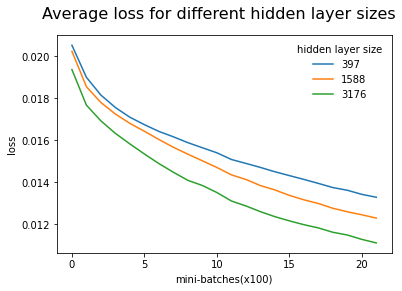

In [13]:
'''CE/MSE LOSS with H2'''
# Plot average loss per mini-batches
fig, ax = plt.subplots()
fig.suptitle(f'Average loss for different hidden layer sizes', fontsize=16)
ax.set_xlabel('mini-batches(x100)')
ax.set_ylabel('loss')

for hiden_layer in [397, 1588, 3176]:  
    
    print('================================')
    print(f"Hidden layer size is {hiden_layer}")
    
    # Initialize neuralNet
    model=Net(H1_size=794, H2_size=hiden_layer)

    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

    # Initialize Criterion
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()

    # Set train function arguments with partial
    tr = partial(Train, epochs=2, loss_func=criterion, opt=optimizer, target_one_hot=True)

    # Begin KFold training with given model and train function
    results = kFoldTrain(net=model, trainer=tr, dt_set=dataset, k_folds=5, batch_s=50)

    # Caclulate and print average accuracy
    average_accuracy = np.array(list(results["accuracy"].values())).mean()
    
    print(f'{len(results["accuracy"])}-Fold average accuracy is: {round(average_accuracy, 2)}')
    
    ax.plot(np.array(results["loss"]).mean(axis=0), label=f"{hiden_layer}")

plt.legend(loc="upper right", title="hidden layer size", frameon=False)
plt.show()
fig.savefig(f'./plots/MSE_plot_Η2.png', dpi=300, bbox_inches='tight')

**η)** Επειδή χρησιμοποιούμε **CV** για βελτιστοποίηση των υπερ παραμέτρων στα προηγούμενα ερωτήματα εκπαίδευσα το κάθε fold με τον ίδιο αριθμό epoch. Είναι πιθανό να χρησιμοποιηθεί **early stoping** για κριτήριο τερματισμού αλλά αυτό προϋποθέτει το διαχωρισμό του κάθε fold σε τρία σετ (training, validation για early stoping και validation για CV). Παρακάτω φαίνεται η **Train_with_early_stop** που υλοποιεί το συγκεκριμένο κριτήριο τερματισμού χρησιμοποιώντας έναν scheduler που μετά απο κάθε epoch εξετάζει την τιμή της **eval**.

In [24]:
def eval(model, val_dl, loss_func, one_hot=False):
    
    total_loss = 0
    
    model.eval()
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_dl):
            
            # Perform forward pass
            outputs = model(inputs.float())

            # Turn target batch to one-hot for MSELoss
            if one_hot:
                targets = F.one_hot(targets, num_classes=10).float()
            
            # Compute loss
            total_loss =+ loss_func(outputs.float(), targets).item()
        
    return torch.tensor(total_loss / len(val_dl))

In [47]:
def Train_with_early_stop(loss_func, opt, model, train_dl, val_dl, target_one_hot=False):   
    
    model.train()
    
    # Accumulate loss values for ploting 
    loss_values = []
    
    # Initialize scheduler
    es = EarlyStopping(patience=1)
    
    epoch = 0
    
    # Run the training loop for defined number of epochs
    while True:

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dl, 0):

            # Zero the gradients
            opt.zero_grad()

            # Perform forward pass
            outputs = model(inputs.float())

            # Turn target batch to one-hot for MSELoss
            if target_one_hot:
                targets = F.one_hot(targets, num_classes=10).float()
            
            # Compute loss
            loss = loss_func(outputs.float(), targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            opt.step()

            # Print statistics
            current_loss += loss.item()
            
            if i % 100 == 99:
                #print(f'Loss after {i + 1} mini-batches: {current_loss / 500}')
                loss_values.append(current_loss / 500)
                current_loss = 0.0
                
        epoch += 1
        # evalution on dev set (i.e., holdout from training)
        metric = eval(model, val_dl, loss_func, target_one_hot)  
        if es.step(metric): break  # early stop criterion is met
            

    return loss_values

In [48]:
# Caluculate mean of lists with different sizes -> Used when early stoping
# From stackOverflow -> https://stackoverflow.com/a/59281468
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

### Α3. Μεταβολές στον ρυθμό εκπαίδευσης και σταθεράς ορμής

Βελτιστοποίηση των παραμέτρων **m** και **lr**.

Το δυτικό που δίνει τα καλύτερα αποτελέσματα και που χρησιμοποιείτε για την αξιολόγηση των παραμέτρων έχει ένα κρυφό επίπεδο με 794 νευρώνες. 
Για εκπαίδευση με **5-fold** και **early-stoping** τα αποτελέσματα είναι τα παρακάτω:

| ρυθμός εκπαίδευσης(lr) | σταθερά ορμής(m) | CEloss  | ΜSE |
| :- | :- | :- | :- |
|0.001 | 0.2   |89.34 | 84.34 |   
|0.001 | 0.6   |91.41 | 86.38 |
|0.05  | 0.6   |97.47 | 96.46 |
|0.1   | 0.6   |97.42 | 96.91 |

Από τα αποτελέσματα φαίνεται και πάλη ότι η εκπαίδευση με **CE** είναι καλύτερη για προβλήματα clasification. Αναφορικά με της παραμέτρους **lr** και **m**
φαίνεται ότι περνούμε τα καλύτερα αποτελέσματα με m = 0.6 και learning rate μετάξι 0.05 και 0.1 αυξάνοντας έτσι την ταχύτητα με την οποία το δυτικό κινείτε προς το στόχο. Αναλυτικά:
- Στο πρώτο πείραμα πετυχαίνουμε καλύτερα αποτελέσματα με την προσθήκη momentum (το lr ήταν ίδιο) από το Α2.
- Στο δεύτερο έχουμε ελαφρώς καλύτερα αποτελέσματα από πριν με την αύξηση του momentum.
- Στο τρίτο και τέταρτο τα αποτελέσματα είναι παρόμοια με την διαφορά ότι η εκπαίδευση με lr = 0.1 χρειάστηκε λιγότερες επαναλήψεις για την σύγκλιση.


<div style="text-align:center">

### CE loss diagram

<img src="./plots/CE_lr_m.png" alt="drawing" width="500"/>

### MSE loss diagram
<img src="./plots/MSE_lr_m.png" alt="drawing" width="500"/>
    
<div style="text-align:center">

In [ ]:
'''CE/MSE LOSS learning rate-momentum'''

from early_stop import EarlyStopping

# Plot average loss per mini-batches
fig, ax = plt.subplots()
fig.suptitle(f'Average loss for different l-m pairs', fontsize=16)
ax.set_xlabel('mini-batches(x100)')
ax.set_ylabel('loss')

value_pairs = [
    (0.001, 0.2),
    (0.001, 0.6),
    (0.05, 0.6),
    (0.1, 0.6)
]

for i, (l, m) in enumerate(value_pairs):  
    
    print('================================')
    print(f"pair -> lr={l}, m={m}")
    
    # Initialize neuralNet
    model=Net(H1_size=794)

    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=l, momentum=m) 

    # Initialize Criterion
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()

    # Set train function arguments with partial
    tr = partial(Train_with_early_stop, 
                 loss_func=criterion, 
                 opt=optimizer, 
                 target_one_hot=True)

    # Begin KFold training with given model and train function
    results = kFoldTrain(net=model, 
                         trainer=tr, 
                         dt_set=dataset, 
                         k_folds=5, 
                         batch_s=50,
                         early_stop=True)

    # Caclulate and print average accuracy
    average_accuracy = np.array(list(results["accuracy"].values())).mean()
    
    print(f'{len(results["accuracy"])}-Fold average accuracy is: {round(average_accuracy, 2)}')
    
    y, error = tolerant_mean(results["loss"])
    ax.plot(np.arange(len(y))+1, y, label=f"lr={l}, m={m}")
    ax.fill_between(np.arange(len(y))+1, y-error, y+error, alpha=0.2)

plt.legend(loc="upper right", title="lr-m pairs", frameon=False)
plt.show()
fig.savefig(f'./plots/MSE_lr_m.png', dpi=300, bbox_inches='tight')

### Α4. Ομαλοποίηση

Βελτιστοποίηση της παραμέτρου **weigh_decay(wd)**.

Το δυτικό που δίνει τα καλύτερα αποτελέσματα και που χρησιμοποιείτε για την αξιολόγηση των παραμέτρων έχει ένα κρυφό επίπεδο με 794 νευρώνες.
Ακόμα χρησιμοποιήθηκε learning rate 0.05 και momentum = 0.6.
Για εκπαίδευση με **5-fold** και **early-stoping** τα αποτελέσματα είναι τα παρακάτω:

| ομαλοποίηση βαρών(wd) | CEloss  | ΜSE |
| :- | :- | :- |
|0.1 | 89.0  | 72.62 |   
|0.5 | 72.2  | 11.85 |
|0.9 | 54.97 | 10.54 |

Από τα αποτελέσματα φαίνεται ότι μεγάλες τιμές **wd** εισάγουν μεγάλο "penalty" στα weights κάνοντας τα έτσι να τείνουν προς το 0 και ως εκ τούτου αποτρέπουν το δυτικό να μάθει από τα δεδομένα. Μικρές τιμές **wd** είναι ωφέλιμες σε περίπτωση που το δίκτυο δεν γενικεύει επαρκώς από τα δεδομένα μάθησης.
Στην συγκεκριμένη περίπτωση επειδή το δίκτυο είναι μικρό (έχει μόνο ένα κρυφό επίπεδο) και επόμενος κάνει δύσκολα overfit, η εφαρμογή weight decay (ακόμα και με wd=0.1) μειώνει την αποτελεσματικότητα του δικτιού (απο ac=97 σε ac=89 για CE) σε καινούρια δεδομένα.

<div style="text-align:center">  

### CE loss diagram

<img src="./plots/CE_weight_decay.png" alt="drawing" width="500"/>

### MSE loss diagram
<img src="./plots/MSE_weight_decay.png" alt="drawing" width="500"/>
    
<div style="text-align:center">

In [ ]:
'''CE/MSE LOSS weight_decay'''

from early_stop import EarlyStopping

# Plot average loss per mini-batches
fig, ax = plt.subplots()
fig.suptitle(f'Average loss for different weight_decay values', fontsize=16)
ax.set_xlabel('mini-batches(x100)')
ax.set_ylabel('loss')

for i, wd in enumerate([0.1, 0.5, 0.9]):  
    
    print('================================')
    print(f"weight_decay={wd}")
    
    # Initialize neuralNet
    model=Net(H1_size=794)

    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=0.05, 
                                momentum=0.6,
                                weight_decay=wd
                               ) 

    # Initialize Criterion
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()

    # Set train function arguments with partial
    tr = partial(Train_with_early_stop, 
                 loss_func=criterion, 
                 opt=optimizer, 
                 target_one_hot=True
                )

    # Begin KFold training with given model and train function
    results = kFoldTrain(net=model, 
                         trainer=tr, 
                         dt_set=dataset, 
                         k_folds=5, 
                         batch_s=50,
                         early_stop=True
                        )

    # Caclulate and print average accuracy
    average_accuracy = np.array(list(results["accuracy"].values())).mean()
    
    print(f'{len(results["accuracy"])}-Fold average accuracy is: {round(average_accuracy, 2)}')
    
    y, error = tolerant_mean(results["loss"])
    ax.plot(np.arange(len(y))+1, y, label=f"wd={wd}")
    ax.fill_between(np.arange(len(y))+1, y-error, y+error, alpha=0.2)

plt.legend(loc="upper right", title="weight_decay value", frameon=False)
plt.show()
fig.savefig(f'./plots/MSE_weight_decay.png', dpi=300, bbox_inches='tight')

### A5. Convolutional Neural Network

Τα δυο **CNN** που θα αξιολογηθούν σε αυτό το ερώτημα είναι τα παρακάτω:

1. Το **CNN1** αποτελείτε από τρία επίπεδα συνέλιξης με μέγεθος kernel ίσο με 5 από τα οποία καθένα ακολουθείτε από ένα επίπεδο **max pool** με μέγεθος window 2x2 και ένα επίπεδο **dropout** που με πιθανότητα 50% θέτει σε 0 μέρη του τενσορα εισόδου του. Έπειτα η έξοδος γίνεται **flatten** με σκοπό να περάσει από δυο τελευταία **linear** επίπεδα. Για activation function παντού χρησιμοποιείτε η **Relu**. 

In [62]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

2. Το **CNN2** είναι ακριβός ίδιο με το πρώτο με την διαφορά ότι δεν εφαρμόζεται drop out και υπαρχει μονο ενα Linear επιπεδο.

In [63]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = x.view(-1,3*3*64 )
        x = self.fc1(x)
        return x

FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Accuracy for fold 0: 98 %
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Accuracy for fold 1: 98 %
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 2: 98 %
--------------------------------
FOLD 3
--------------------------------
Starting epoch 1
Starting epoch 2
Accuracy for fold 3: 99 %
--------------------------------
FOLD 4
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Accuracy for fold 4: 99 %
--------------------------------
5-Fold average accuracy is: 99.02


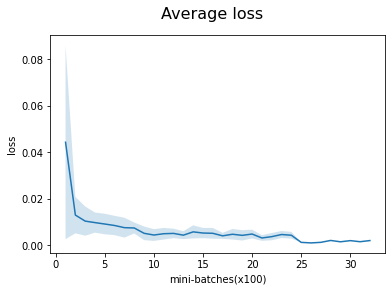

In [61]:
'''CE/MSE LOSS weight_decay'''

from early_stop import EarlyStopping

# Plot average loss per mini-batches
fig, ax = plt.subplots()
fig.suptitle(f'Average loss', fontsize=16)
ax.set_xlabel('mini-batches(x100)')
ax.set_ylabel('loss')
    
print('================================')

# Initialize neuralNet
model=CNN2()

# Initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.6) 

# Initialize Criterion
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

# Set train function arguments with partial
tr = partial(Train_with_early_stop, 
             loss_func=criterion, 
             opt=optimizer, 
             target_one_hot=False
            )

# Begin KFold training with given model and train function
results = kFoldTrain(net=model, 
                     trainer=tr, 
                     dt_set=dataset, 
                     k_folds=5, 
                     batch_s=50,
                     early_stop=True
                    )

# Caclulate and print average accuracy
average_accuracy = np.array(list(results["accuracy"].values())).mean()

print(f'{len(results["accuracy"])}-Fold average accuracy is: {round(average_accuracy, 2)}')

y, error = tolerant_mean(results["loss"])
ax.plot(np.arange(len(y))+1, y)
ax.fill_between(np.arange(len(y))+1, y-error, y+error, alpha=0.2)
plt.show()
fig.savefig(f'./plots/CE_CNN2.png', dpi=300, bbox_inches='tight')

Η εκπαίδευση έγινε με 5-fold και early-stoping. H παράμετροι του SGD ειναι m=0.6 και lr=0.05. Τα αποτελέσματα είναι τα παρακάτω:

| CNN model | CE loss  | ΜSE |
| :- | :- | :- |
| CNN1 | 99.24 | 97.7 |   
| CNN2 | 99.02 | 98.8 |

<center>

### CNN1 CE loss diagram

<img src="./plots/CE_CNN.png" alt="drawing" width="500"/>

### CNN1 MSE loss diagram
<img src="./plots/MSE_CNN.png" alt="drawing" width="500"/>
    
### CNN2 CE loss diagram

<img src="./plots/CE_CNN2.png" alt="drawing" width="500"/>

### CNN2 MSE loss diagram
<img src="./plots/MSE_CNN2.png" alt="drawing" width="500"/>
    
</center>


Από τα παραπάνω γίνεται αντιληπτό ότι τα **CNN** μοντέλα είναι αποτελεσματικότερα από τα **FNN** σε δεδομένα όπως φωτογραφίες που υπάρχει συσχετίσει μεταξύ των τιμών τον pixel που βρίσκονται κοντά στο δυσδιάστατο επίπεδο. Τα δυο μοντέλα διαφέρουν κύριος στην ύπαρξη η οχι regularization μέσο drop out. Παρόλα αυτά και τα δυο πετυχαίνουν accuracy πάνω από 98% για CEloss και 97% για MSE.